#### Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

#### Base de dados

In [2]:
df = pd.read_csv("../dados/plataforma.csv")

In [3]:
df.shape

(7, 27)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 27 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   platform                                          7 non-null      int64  
 1   water_depth                                       7 non-null      int64  
 2   weight                                            7 non-null      int64  
 3   installation_date                                 7 non-null      int64  
 4   type_of_production (1 oil and gas; 2 oil; 3 gas)  7 non-null      int64  
 5   number_of_legs                                    7 non-null      int64  
 6   number_of_piles                                   7 non-null      int64  
 7   height_of_jacket_or_sub-structure                 7 non-null      float64
 8   distance_to_coast                                 7 non-null      int64  
 9   risk_to_other_users-compl

In [5]:
platform_remove = ['platform']

In [6]:
df.drop(platform_remove, axis=1, inplace=True)

In [7]:
df.shape

(7, 26)

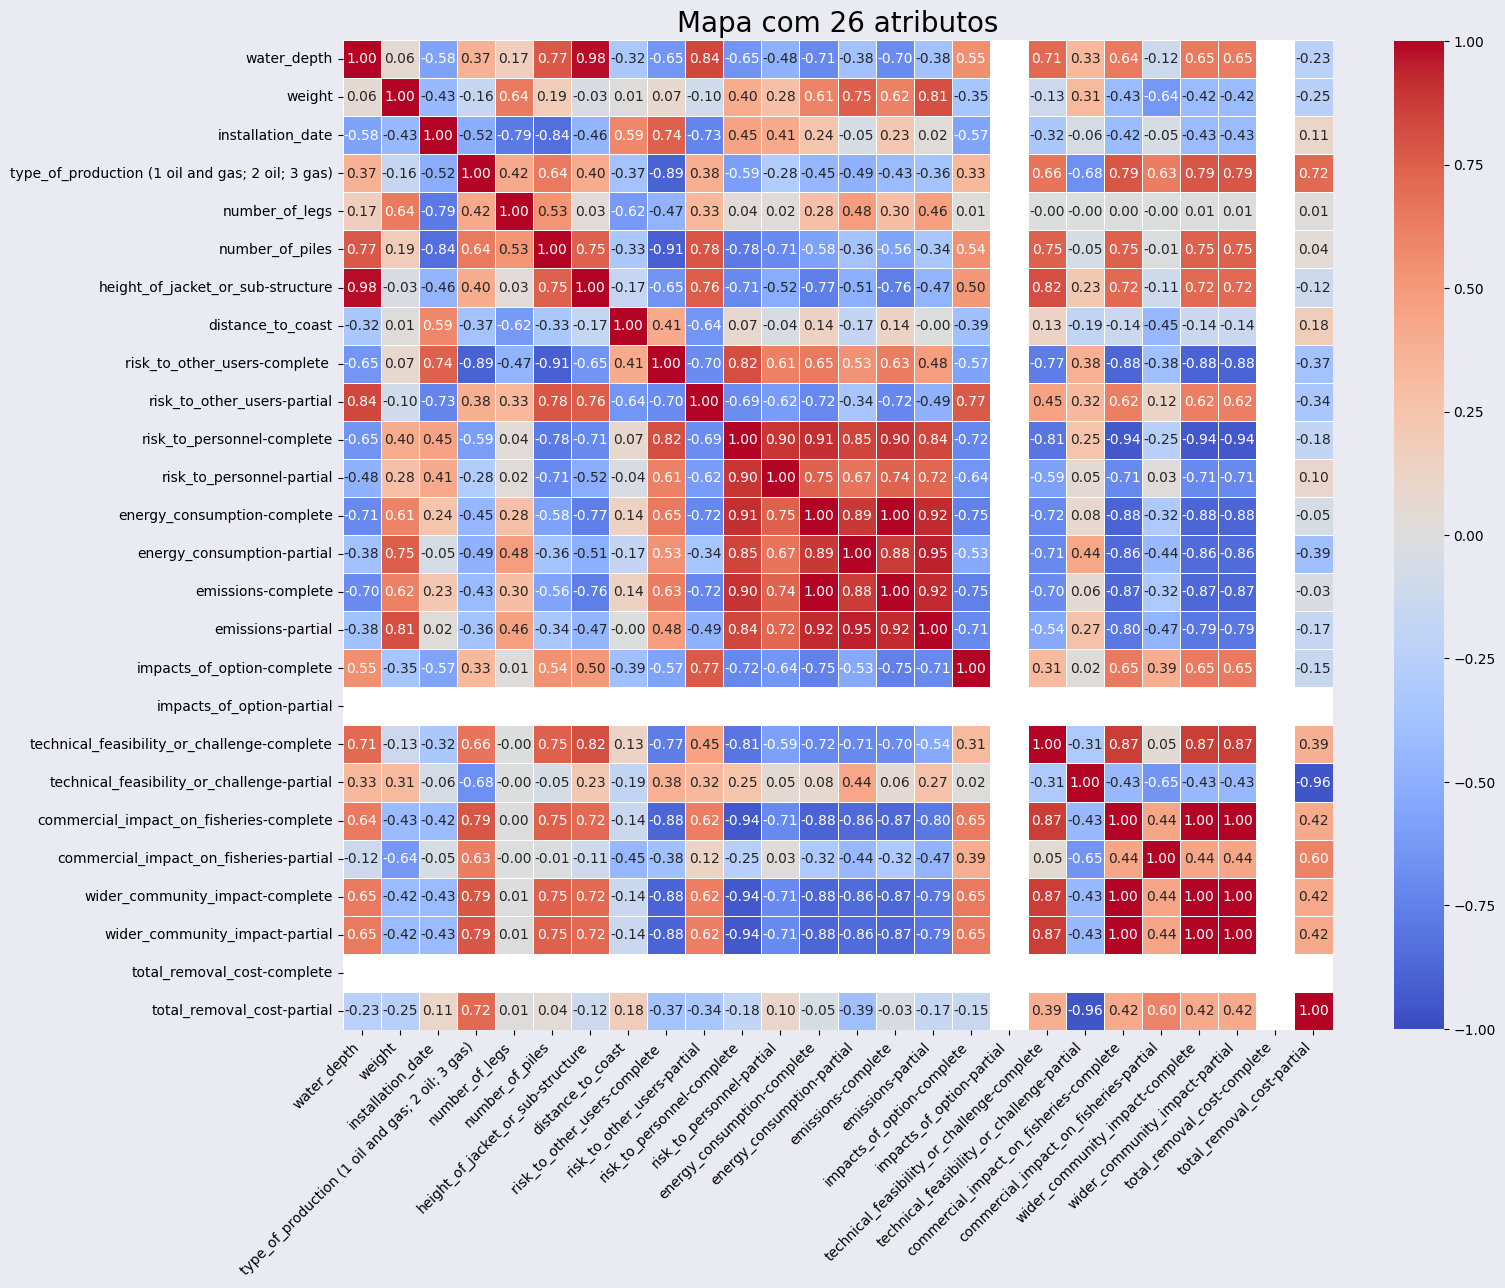

In [8]:
matriz_correlacao = df.corr()

plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685}
)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Mapa com 26 atributos', fontsize=20)

plt.tight_layout()

plt.show()

In [9]:
impacts_partial_and_cost_complete = df[['impacts_of_option-partial', 'total_removal_cost-complete']]

In [10]:
print(impacts_partial_and_cost_complete)

   impacts_of_option-partial  total_removal_cost-complete
0                          1                            1
1                          1                            1
2                          1                            1
3                          1                            1
4                          1                            1
5                          1                            1
6                          1                            1


In [11]:
df

,water_depth,weight,installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure,distance_to_coast,risk_to_other_users-complete,risk_to_other_users-partial,...,impacts_of_option-complete,impacts_of_option-partial,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-complete,total_removal_cost-partial
0,99,22000,1988,1,8,8,114.0,187,1,0.000000e+00,...,0.43,1,0.00,1.00,0.79,0.78,0.50,0.50,1,0.56
1,112,30364,1983,1,8,9,123.0,207,1,0.000000e+00,...,0.51,1,0.00,1.00,0.79,0.78,0.50,0.50,1,0.56
2,141,15561,1978,2,8,26,147.0,120,0,2.500000e-05,...,0.66,1,0.25,1.00,1.00,0.94,1.00,1.00,1,0.53
3,156,27647,1980,2,8,32,166.0,240,0,1.500000e-05,...,0.53,1,0.64,1.00,1.00,0.66,1.00,1.00,1,0.57
4,103,18584,1983,3,8,20,122.5,230,0,7.800000e-08,...,0.53,1,0.39,0.15,1.00,0.99,1.00,1.00,1,0.73
5,144,17500,1983,3,8,20,154.0,130,0,1.335933e-05,...,0.53,1,0.45,0.70,1.00,1.00,1.00,1.00,1,0.66
6,116,10054,1993,1,4,5,136.0,282,1,0.000000e+00,...,0.53,1,0.29,0.81,0.93,0.86,0.83,0.83,1,0.60


In [12]:
remove_impacts_partial_and_cost_complete = ['impacts_of_option-partial', 'total_removal_cost-complete']

In [13]:
df.drop(remove_impacts_partial_and_cost_complete, axis=1, inplace=True)

In [14]:
df.shape

(7, 24)

#### Aplicação da GAN

##### Gerador

In [15]:
class Gerador(nn.Module):
    """
    O gerador recebe um vetor de entrada (contendo números aleatórios) e mapeia para o espaço de saída desejado, 
    produzindo um registro sintético.

    Parâmetros:
        - tamanho_entrada (int): O tamanho do vetor de entrada, que representa a dimensão do espaço latente.
        - tamanho_saida (int): O tamanho do vetor de saída, que representa a dimensão do registro sintético.
    """
    
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(Gerador, self).__init__()
        
        # Definição da arquitetura do modelo
        self.modelo = nn.Sequential(
            nn.Linear(tamanho_entrada, 128), # Primeira camada de entrada (linear)
            nn.ReLU(), # Capacitar não-linearidade
            nn.Linear(128, tamanho_saida), # Segunda camada de saída
            nn.Tanh() # Valores de saída no intervalo de (0 e 1)
        )

    def forward(self, x):
        """
        Essa função passar os dados de entrada através do modelo. Recebe o tensor de entrada "x (torch.Tensor)" e retorna
        o tensor de saída gerada pelo modelo. Em PyTorch, tensor são unidades básicas para trabalhar com redes neurais.

        Parâmetros:
            - x (torch.Tensor): O tensor de entrada.
        """
        return self.modelo(x)

Como funciona a arquitetura do `gerador`:

1. O vetor de entrada é fornecido ao gerador, que é uma rede neural composta por camadas lineares.

2. A primeira camada linear nn.Linear(tamanho_entrada, 128) mapeia o vetor de entrada para um vetor de características com 128 elementos. Cada elemento deste vetor representa a saída de um neurônio na camada oculta.

3. Após a primeira camada linear, a função de ativação ReLU é aplicada a cada elemento do vetor de características. O que introduz não-linearidade na rede, visando que ela aprenda relações mais complexas nos dados.

4. Em seguida, a segunda camada linear nn.Linear(128, tamanho_saida) mapeia o vetor de características para um vetor de saída com o tamanho especificado pelo parâmetro tamanho_saida. Cada elemento deste vetor representa uma componente da saída final do gerador.

5. Por último, a função de ativação Tangente Hiperbólica (Tanh) é aplicada a cada elemento do vetor de saída, normalizando os valores de saída para o intervalo entre -1 e 1.

##### Discriminador

In [16]:
class Discriminador(nn.Module):
    """
    Esta classe recebe um vetor de entrada (representando um registro) e produz uma única saída, 
    que representa a probabilidade do registro ser real.

    Parâmetros:
        - tamanho_entrada (int): O tamanho do vetor de entrada, que representa a dimensão do registro.
    """

    def __init__(self, tamanho_entrada):
        super(Discriminador, self).__init__()

        # Definição da arquitetura do modelo
        self.modelo = nn.Sequential(
            nn.Linear(tamanho_entrada, 128), # Primeira camada de entrada (linear)
            nn.ReLU(), # Capacitar não-linearidade
            nn.Linear(128, 1), 
            nn.Sigmoid() # Saídas em (0 e 1)
        )

    def forward(self, x):
        """
        Essa função passar os dados de entrada através do modelo. Recebe o tensor de entrada "x (torch.Tensor)" e retorna
        o tensor de saída que da a probabilidade do registro ser real. 
        
        Parâmetros:
            - x (torch.Tensor): O tensor de entrada.
        """
        return self.modelo(x)

Como funciona a arquitetura do `discriminador`:

1. O vetor de entrada, que representa um registro (real ou sintético), é fornecido ao discriminador.

2. A primeira camada linear nn.Linear(tamanho_entrada, 128) mapeia o vetor de entrada para um vetor de características com 128 elementos. Cada elemento deste vetor representa a saída de um neurônio na camada oculta.

3. Após a primeira camada linear, a função de ativação ReLU é aplicada a cada elemento do vetor de características. O que introduz não-linearidade na rede, visando que ela aprenda relações mais complexas nos dados.

4. Em seguida, a segunda camada linear nn.Linear(128, 1) mapeia o vetor de características (após a aplicação da função ReLU) para uma única saída. Esta saída representa a probabilidade de o registro ser real.

5. Por fim, a função de ativação Sigmoid é aplicada à saída da última camada linear, produzindo uma saída no intervalo entre 0 e 1, representando a probabilidade do registro ser real.

##### Treinando o discriminador

In [17]:
def treinar_discriminador(discriminador, otimizador, dados_reais, dados_falsos):
    otimizador.zero_grad() # Zera os gradientes
    previsao_real = discriminador(dados_reais) # Passando as 7 instâncias originais pro discriminador
    perda_real = criterio(previsao_real, torch.ones_like(previsao_real)) # Próximo de 1 = verdadeiro, próximo de 0 = falso
    perda_real.backward() # Algoritmo de backpropagation (Feed-Forward e Feed-Backward)

    previsao_falsa = discriminador(dados_falsos)
    perda_falsa = criterio(previsao_falsa, torch.zeros_like(previsao_falsa)) # Próximo de 0 = verdadeiro, próximo de 1 = falso
    perda_falsa.backward()

    otimizador.step() # Atualiza os gradientes

    return perda_real + perda_falsa

Como funciona o treinamento do `discriminador`:
1. otimizador.zero_grad(): necessário antes de calcular os gradientes para uma nova passagem de treinamento, caso contrário, os gradientes seriam acumulados.

2. previsao_real = discriminador(dados_reais): Aqui, estamos passando os dados reais para o discriminador e obtendo as previsões dele.

3. perda_real = criterio(previsao_real, torch.ones_like(previsao_real)): Calculamos a perda (ou erro) do discriminador em relação aos dados reais. Aqui, estamos comparando as previsões do discriminador com um tensor de uns (representando os rótulos "verdadeiros"). O objetivo é minimizar essa perda para que o discriminador seja capaz de distinguir corretamente os dados reais.

4. perda_real.backward(): realiza a retropropagação (backpropagation). Aqui, os gradientes são calculados automaticamente para todos os tensores, sendo usados para atualizar os pesos da rede durante o próximo passo de otimização.

5. previsao_falsa = discriminador(dados_falsos): Agora, passamos os dados falsos (gerados pelo gerador) para o discriminador e obtemos as previsões dele.

6. perda_falsa = criterio(previsao_falsa, torch.zeros_like(previsao_falsa)): Calculamos a perda do discriminador em relação aos dados falsos. Aqui, estamos comparando as previsões do discriminador com um tensor de zeros (representando os rótulos "falsos"). O objetivo é minimizar essa perda para que o discriminador seja capaz de distinguir corretamente os dados falsos.

7. perda_falsa.backward(): Realizamos novamente o passo de retropropagação para calcular os gradientes e atualizar os pesos da rede com base na perda em relação aos dados falsos.

8. otimizador.step(): Atualiza os parâmetros do discriminador com base nos gradientes calculados durante o passo de retropropagação. Isso é feito chamando o método step() do otimizador. Por isso, no começo utilizamos otimizador.zero_grad(),

9. Por fim, retornamos a soma das perdas do discriminador em relação aos dados reais e falsos.

##### Treinando o gerador

In [18]:
def treinar_gerador(gerador, otimizador, dados_falsos): # Etapa de duelo entre o gerador e o discriminador
    otimizador.zero_grad()
    previsao = discriminador(dados_falsos) 
    perda = criterio(previsao, torch.ones_like(previsao))
    perda.backward()
    otimizador.step()
    return perda

Como funciona o treinamento do `gerador`:
1. otimizador.zero_grad(): necessário antes de calcular os gradientes para uma nova passagem de treinamento.

2. previsao = discriminador(dados_falsos): Aqui, passamos os dados falsos (gerados pelo gerador) para o discriminador e obtemos as previsões dele. O objetivo do gerador é enganar o discriminador para que ele preveja que os dados falsos são reais.

3. perda = criterio(previsao, torch.ones_like(previsao)): Calculamos a perda do gerador com base nas previsões do discriminador. Neste caso, estamos comparando as previsões do discriminador com um tensor de uns (representando os rótulos "verdadeiros"), mas do ponto de vista do gerador, ele quer que o discriminador pense que os dados falsos são reais. Portanto, o objetivo do gerador é minimizar essa perda.

4. perda.backward(): Realizamos o passo de retropropagação para calcular os gradientes e atualizar os pesos do gerador com base na perda calculada.

5. otimizador.step(): Atualiza os parâmetros do gerador com base nos gradientes calculados durante o passo de retropropagação.

6. Por fim, retornamos a perda do gerador.

##### Função de normalização

In [19]:
def normalizar(df): # Garante que os dados estejam no intervalo de (0 e 1)
    return (df - df.min()) / (df.max() - df.min())

##### Função de desnormalização

In [20]:
def desnormalizar(df, df_normalizado): # Retorna os valores ao original
    return df_normalizado * (df.max() - df.min()) + df.min()

##### Normalizando os dados

In [21]:
df_normalizado = normalizar(df)

##### Definindo dimensões

In [22]:
tamanho_entrada = len(df.columns)  # Aplica em todas as colunas da base de dados (24)
tamanho_saida = tamanho_entrada

##### Ajuste de hiperparâmetros

In [23]:
numero_epocas = 1000 # Quantidade de iterações em cima da base
tamanho_batch = 32 # Dados divididos em lotes

# Cálculo das iterações = numero_epocas * tamanho_batch

taxa_aprendizado = 0.001
quantidade_novos_registros = 1000

In [24]:
# Iniciando o gerador e o discriminador
gerador = Gerador(tamanho_entrada, tamanho_saida)
discriminador = Discriminador(tamanho_entrada)

In [25]:
# Definindo a função de perda
criterio = nn.BCELoss() # Entropia cruzada para casos binários

# Definindo os otimizadores
otimizador_gerador = optim.Adam(gerador.parameters(), lr=taxa_aprendizado) # Estava usando antes o (SGD)
otimizador_discriminador = optim.Adam(discriminador.parameters(), lr=taxa_aprendizado)

##### Treinando a GAN

In [26]:
for epoca in range(numero_epocas):
    for i in range(0, len(df_normalizado), tamanho_batch):
        # Colocando os dados reais no formato que o PyTorch interpreta
        dados_reais = torch.tensor(df_normalizado.iloc[i:i+tamanho_batch].values, dtype=torch.float32)
        
        # Dados falsos feitos pelo Gerador
        ruido = torch.randn(tamanho_batch, tamanho_entrada)
        dados_falsos = gerador(ruido)

        # Treinando o Discriminador
        perda_discriminador = treinar_discriminador(discriminador, otimizador_discriminador, dados_reais, dados_falsos)

        # Treinando o Gerador
        ruido = torch.randn(tamanho_batch, tamanho_entrada)
        dados_falsos = gerador(ruido)
        perda_gerador = treinar_gerador(gerador, otimizador_gerador, dados_falsos)

    # Imprimir progresso a cada 100 épocas
    if (epoca+1) % 100 == 0:
        print(f"Época [{epoca+1}/{numero_epocas}], Perda do Discriminador: {perda_discriminador.item()}, Perda do Gerador: {perda_gerador.item()}")

Época [100/1000], Perda do Discriminador: 1.2522939443588257, Perda do Gerador: 0.9095994234085083
Época [200/1000], Perda do Discriminador: 0.6810188293457031, Perda do Gerador: 1.4784190654754639
Época [300/1000], Perda do Discriminador: 0.5112040042877197, Perda do Gerador: 1.670096516609192
Época [400/1000], Perda do Discriminador: 0.8848552703857422, Perda do Gerador: 1.2043251991271973
Época [500/1000], Perda do Discriminador: 1.0288914442062378, Perda do Gerador: 1.0754278898239136
Época [600/1000], Perda do Discriminador: 0.9125993251800537, Perda do Gerador: 1.021546721458435
Época [700/1000], Perda do Discriminador: 1.2406102418899536, Perda do Gerador: 0.804517388343811
Época [800/1000], Perda do Discriminador: 1.050901174545288, Perda do Gerador: 0.9338467717170715
Época [900/1000], Perda do Discriminador: 1.236077904701233, Perda do Gerador: 0.8631305694580078
Época [1000/1000], Perda do Discriminador: 1.2116496562957764, Perda do Gerador: 0.7275316715240479


##### Gerando dados sintéticos e aplicando restrições

In [27]:
# Gerar dados sintéticos para toda a base de dados
novos_registros = []
for _ in range(quantidade_novos_registros // tamanho_batch):
    ruido = torch.randn(tamanho_batch, tamanho_entrada)
    batch_sintetico = gerador(ruido).detach().numpy()
    
    # Restrição 1: Valores negativos iguais a zero
    batch_sintetico[batch_sintetico < 0] = 0

    novos_registros.append(batch_sintetico)


# Quando o número de dados gerados não é múltiplo do tamanho do batch
dados_restantes = quantidade_novos_registros % tamanho_batch
if dados_restantes > 0:
    ruido = torch.randn(dados_restantes, tamanho_entrada)
    batch_sintetico = gerador(ruido).detach().numpy()
    
    # Restrição 1: Valores negativos iguais a zero
    batch_sintetico[batch_sintetico < 0] = 0

    novos_registros.append(batch_sintetico)

##### Desnormalizando e salvando

In [28]:
novos_registros = np.concatenate(novos_registros)
novos_registros = desnormalizar(df, pd.DataFrame(novos_registros, columns=df.columns))

In [29]:
novos_registros.to_csv('../dados/registros_gan.csv', index=False)

In [36]:
novos_registros.shape

(1000, 24)

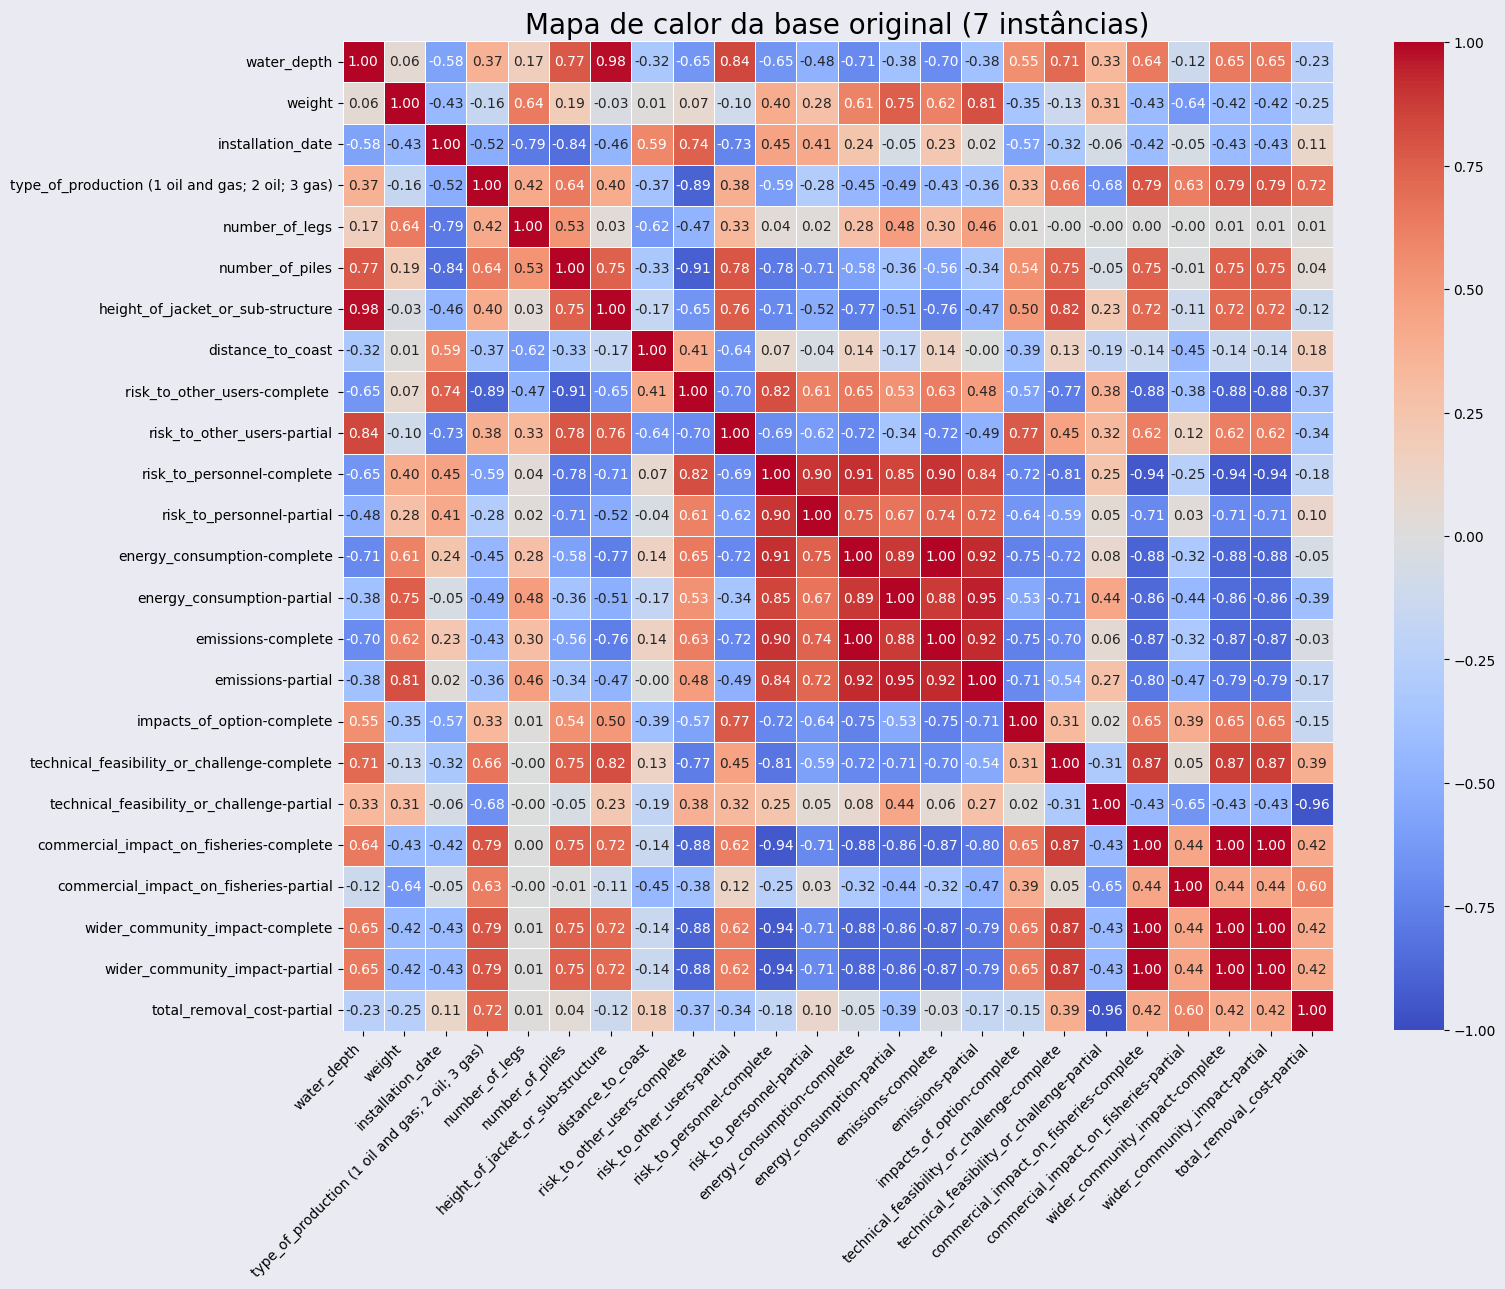

In [30]:
matriz_correlacao = df.corr()

# Plotando o gráfico
plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685} 

)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# título e apresentação do gráfico
plt.title('Mapa de calor da base original (7 instâncias)', fontsize=20)

plt.tight_layout()

plt.show()

In [31]:
df_gan = pd.read_csv("../dados/registros_gan.csv")

In [32]:
df_gan.shape

(1000, 24)

In [33]:
df_gan

,water_depth,weight,installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure,distance_to_coast,risk_to_other_users-complete,risk_to_other_users-partial,...,emissions-complete,emissions-partial,impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-partial
0,126.562646,10054.000000,1978.000000,1.971620,7.272627,20.798900,134.193739,152.517540,0.045843,1.027430e-06,...,33551.641715,40905.751603,0.578933,0.329827,0.668351,0.984826,0.893094,0.980880,0.976672,0.611957
1,139.195073,14392.522774,1978.000000,2.318866,7.736247,26.381362,143.228877,165.934481,0.113409,1.024921e-05,...,24277.000000,42228.535973,0.605012,0.307433,0.724283,0.997300,0.925506,0.996501,0.994995,0.631613
2,114.531446,11174.498984,1978.000000,1.719067,6.938596,14.110456,127.271249,163.949217,0.188365,6.536459e-07,...,35186.207534,39738.486090,0.530147,0.250157,0.522868,0.964691,0.847034,0.952839,0.927257,0.595468
3,122.287871,10054.000000,1978.000000,1.636094,6.667244,16.933786,132.176958,127.815704,0.006190,4.044988e-06,...,30597.253281,37547.720119,0.539665,0.214858,0.557108,0.967866,0.841065,0.944767,0.946380,0.572582
4,99.000000,18781.042102,1978.000000,1.000000,6.781760,19.018631,114.000000,120.000000,0.961123,2.864580e-06,...,75151.100247,56105.834993,0.489854,0.000000,0.950142,0.790000,0.751400,0.599355,0.538956,0.530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,117.696403,12410.835931,1978.855896,1.000000,7.239553,19.827304,125.924873,143.679654,0.743474,6.417172e-06,...,35178.850820,45055.720552,0.522809,0.078349,0.854730,0.925301,0.806973,0.914898,0.885655,0.531557
996,125.275921,10054.000000,1978.000000,1.636600,6.698854,15.800881,129.022979,145.977049,0.096817,4.035774e-06,...,25163.636141,37471.307894,0.558427,0.281583,0.527570,0.965592,0.872415,0.962054,0.946697,0.597744
997,128.320501,10054.000000,1978.000000,2.188679,7.620517,23.818643,141.293791,149.187277,0.064834,5.368518e-06,...,29726.066049,40295.253786,0.599155,0.453844,0.680676,0.996917,0.939286,0.995270,0.995155,0.635365
998,149.969996,15927.843431,1978.000000,2.356950,7.955755,29.232409,155.632089,158.899359,0.080464,1.584265e-05,...,24277.000000,45507.395551,0.638181,0.327630,0.892703,0.999636,0.954459,0.999007,0.999444,0.597713


In [34]:
df

,water_depth,weight,installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure,distance_to_coast,risk_to_other_users-complete,risk_to_other_users-partial,...,emissions-complete,emissions-partial,impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-partial
0,99,22000,1988,1,8,8,114.0,187,1,0.000000e+00,...,87000,58500,0.43,0.00,1.00,0.79,0.78,0.50,0.50,0.56
1,112,30364,1983,1,8,9,123.0,207,1,0.000000e+00,...,92000,64000,0.51,0.00,1.00,0.79,0.78,0.50,0.50,0.56
2,141,15561,1978,2,8,26,147.0,120,0,2.500000e-05,...,24277,31064,0.66,0.25,1.00,1.00,0.94,1.00,1.00,0.53
3,156,27647,1980,2,8,32,166.0,240,0,1.500000e-05,...,40416,45266,0.53,0.64,1.00,1.00,0.66,1.00,1.00,0.57
4,103,18584,1983,3,8,20,122.5,230,0,7.800000e-08,...,59588,41170,0.53,0.39,0.15,1.00,0.99,1.00,1.00,0.73
5,144,17500,1983,3,8,20,154.0,130,0,1.335933e-05,...,42000,44000,0.53,0.45,0.70,1.00,1.00,1.00,1.00,0.66
6,116,10054,1993,1,4,5,136.0,282,1,0.000000e+00,...,37162,32191,0.53,0.29,0.81,0.93,0.86,0.83,0.83,0.60


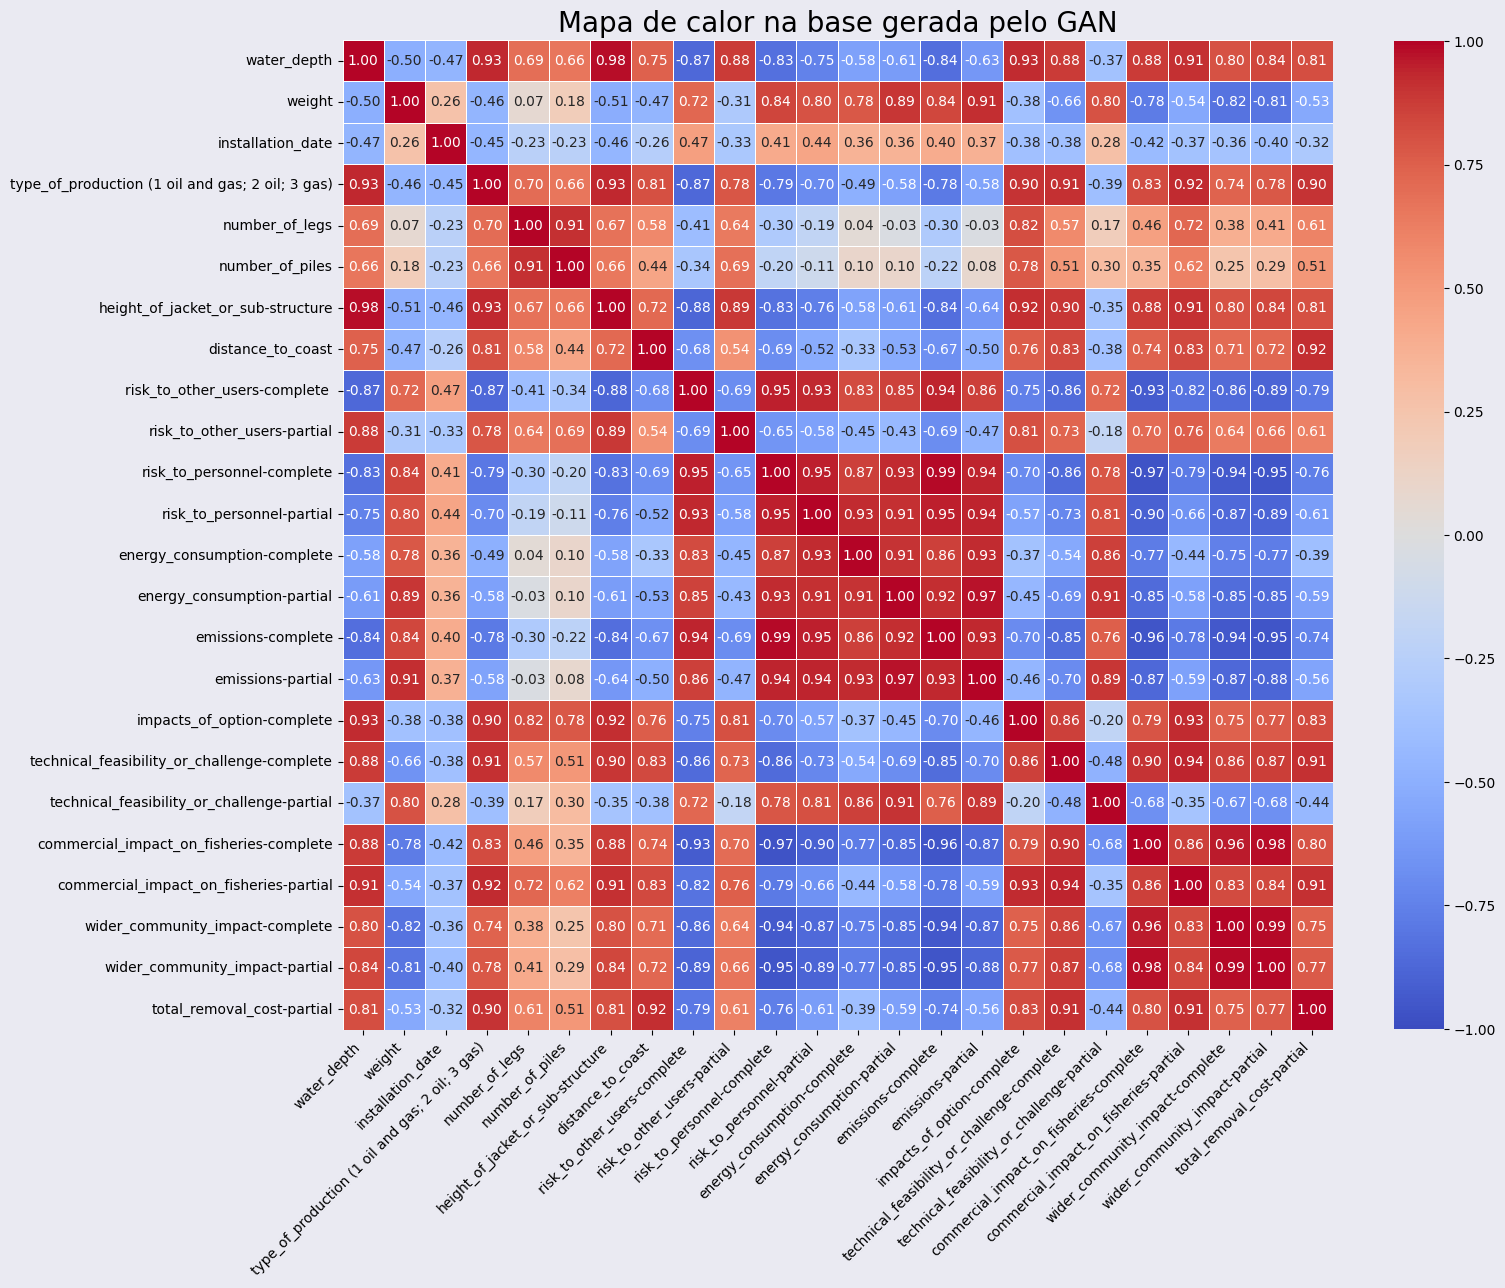

In [35]:
matriz_correlacao_gan = df_gan.corr()

# Plotando o gráfico
plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao_gan,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685} 

)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# título e apresentação do gráfico
plt.title('Mapa de calor na base gerada pelo GAN', fontsize=20)

plt.tight_layout()

plt.show()